# Module 3 Project


In [73]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy import stats
from sklearn import linear_model as lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [74]:
conn = sql.Connection("Northwind_small.sqlite")
c = conn.cursor()

In [75]:

# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]

In [76]:

# Loop to put all tables into pandas dataframes
dfa = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # Cute little function to make a string into variable name
    foo = i+"_df"
    exec(foo + " = df") # => TableName_df
    # Keep all dataframe names in the list to remember what we have
    dfa.append(foo)
    
print(dfa)

['Employee_df', 'Category_df', 'Customer_df', 'Shipper_df', 'Supplier_df', 'Order_df', 'Product_df', 'OrderDetail_df', 'CustomerCustomerDemo_df', 'CustomerDemographic_df', 'Region_df', 'Territory_df', 'EmployeeTerritory_df']


### Question 2. 
   #### Does different shipper have different frieght cost ?
    
   Null Hypothesis ($H_0$): There is no significant frieght cost difference from the shippers.

   $$\mu_A = \mu_B = \mu_C$$

   Alternative Hypothesis ($H_1$): There's significant friehgt cost difference from the shipppers.

   $$\mu_A \neq \mu_B \neq \mu_C$$
   
   First required thing to do is looking in to the data, do some examination.

In [77]:
query = """
SELECT 
    s.CompanyName, o.Freight
FROM 
    [Shipper] s
    JOIN
    [Order] o
    ON 
    o.ShipVia = s.Id
"""
ship_df = pd.read_sql_query(query, conn)
fed_df = ship_df.loc[ship_df.CompanyName == 'Federal Shipping']
speed_df = ship_df.loc[ship_df.CompanyName == 'Speedy Express']
united_df = ship_df.loc[ship_df.CompanyName == 'United Package']

print(ship_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CompanyName    830 non-null object
Freight        830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB
None


In [78]:
print(ship_df.head(10))

        CompanyName  Freight
0  Federal Shipping    32.38
1    Speedy Express    11.61
2    United Package    65.83
3    Speedy Express    41.34
4    United Package    51.30
5    United Package    58.17
6    United Package    22.98
7  Federal Shipping   148.33
8    United Package    13.97
9  Federal Shipping    81.91


In [79]:
print(ship_df.describe())

           Freight
count   830.000000
mean     78.244205
std     116.779294
min       0.020000
25%      13.380000
50%      41.360000
75%      91.430000
max    1007.640000


In [80]:
# Get sample statistics
print(ship_df.groupby('CompanyName').describe())

speed_df = speed_df.drop('CompanyName', axis=1)
united_df = united_df.drop('CompanyName', axis=1)
fed_df = fed_df.drop('CompanyName', axis=1)





ship_mean = ship_df.mean()
ship_sdt = ship_df.std()

fed_std = fed_df.std()
speed_std = speed_df.std()
united_std = united_df.std()

fed_mean = fed_df.mean()
speed_mean = speed_df.mean()
united_mean = united_df.mean()



                 Freight                                                     \
                   count       mean         std   min    25%     50%    75%   
CompanyName                                                                   
Federal Shipping   255.0  80.441216  119.362844  0.40  12.86  36.710  99.49   
Speedy Express     249.0  65.001325   75.393587  0.12  12.75  40.420  89.90   
United Package     326.0  86.640644  138.219262  0.02  14.04  44.135  91.43   

                           
                      max  
CompanyName                
Federal Shipping  1007.64  
Speedy Express     458.78  
United Package     890.78  


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


C:\ProgramData\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


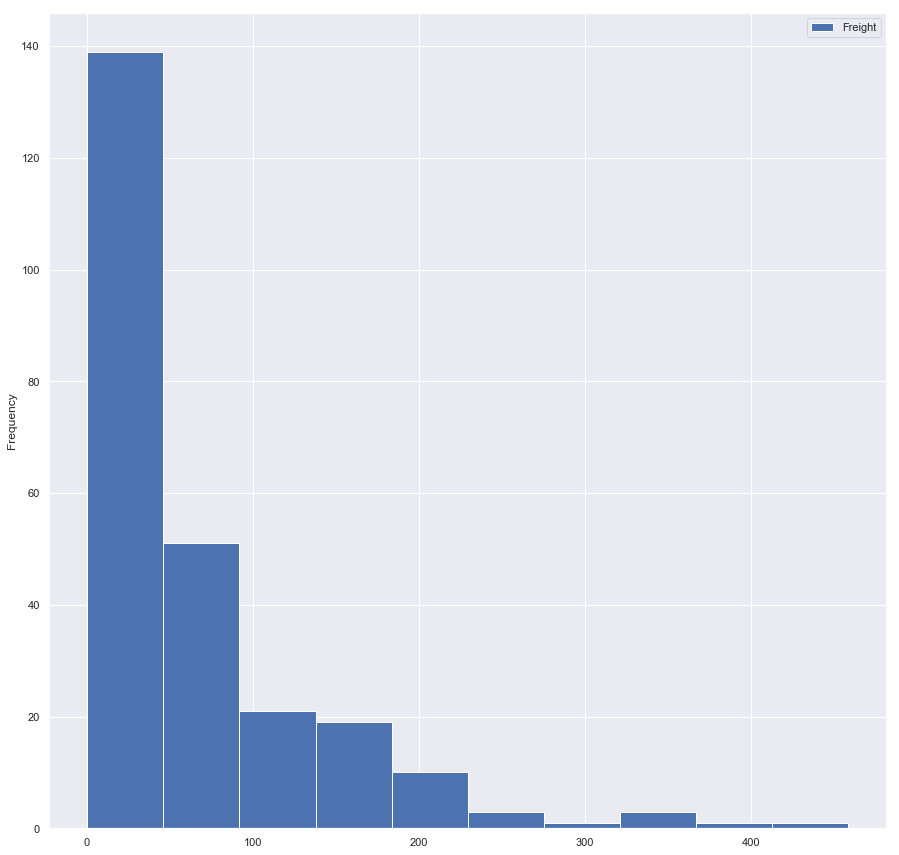

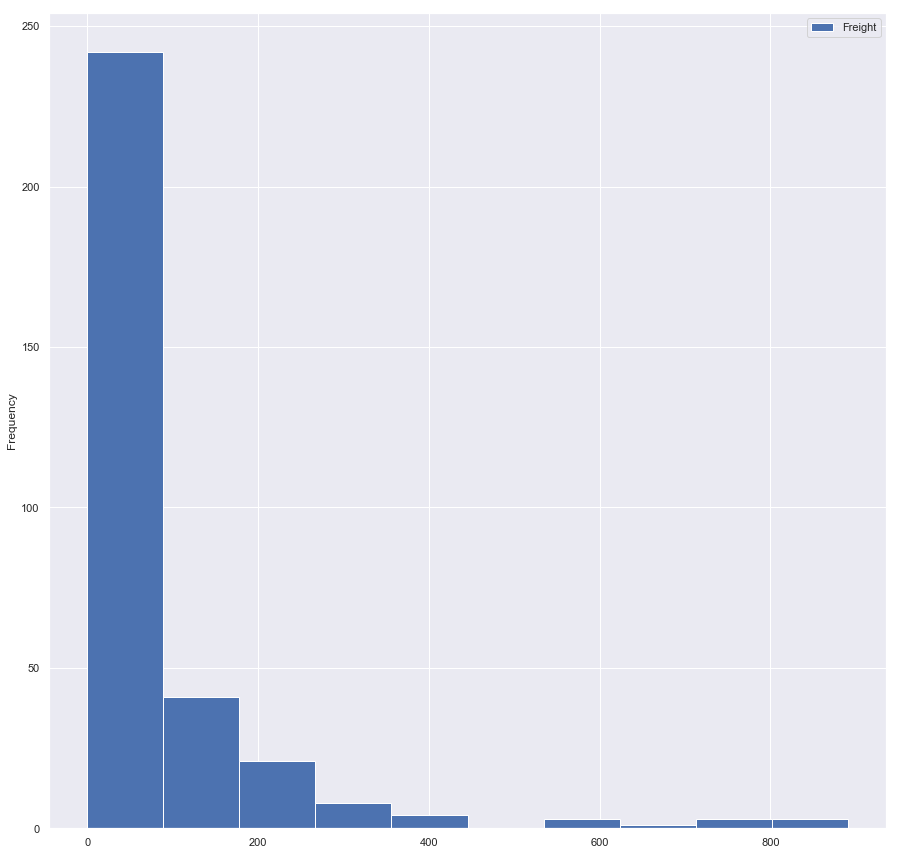

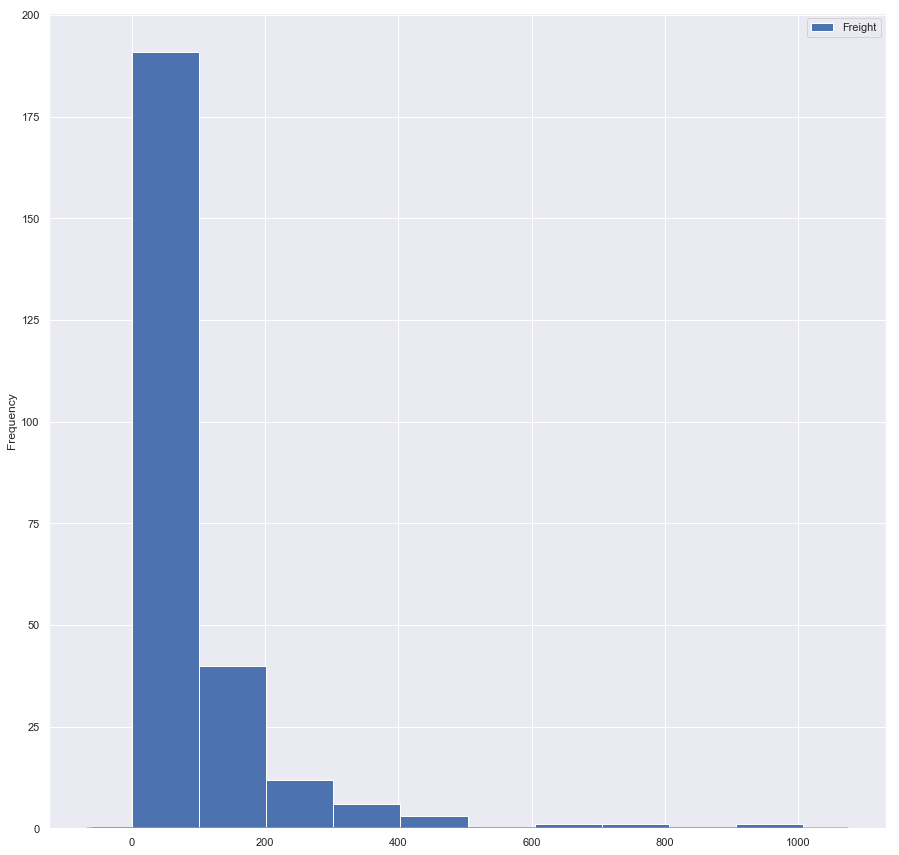

In [96]:
print(speed_df.plot(kind='hist'))
print(united_df.plot(kind='hist'))
print(fed_df.plot(kind='hist'))



C:\ProgramData\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


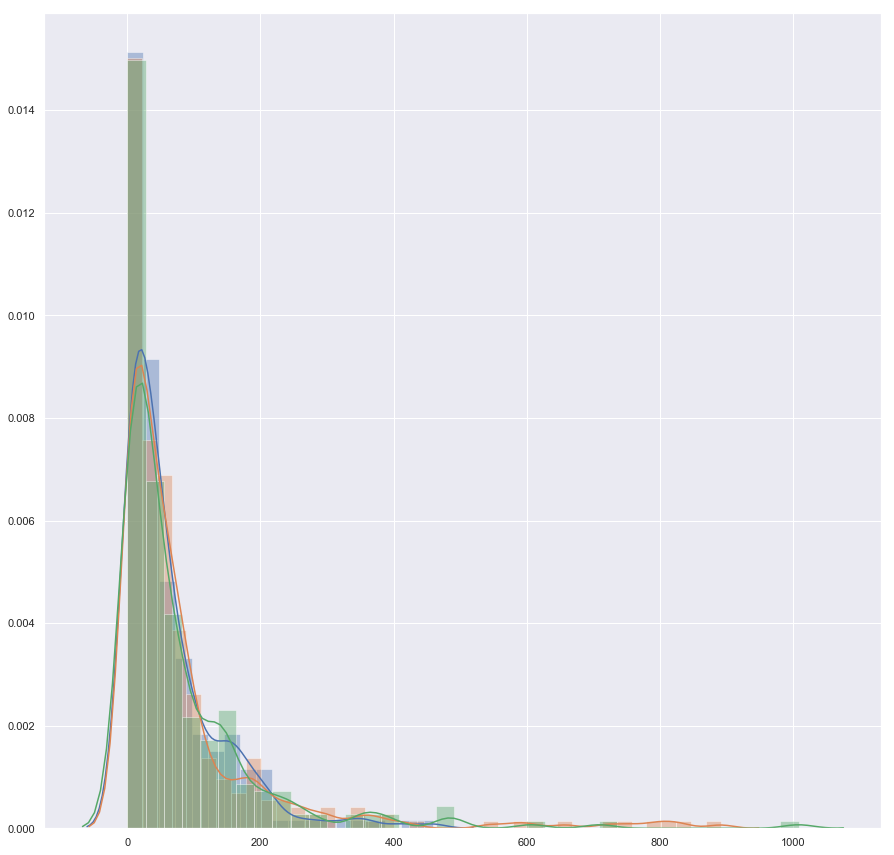

In [97]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(speed_df) # Blue distribution
sns.distplot(united_df)
sns.distplot(fed_df)

For this hypothesis testing, margin of error will be 5%, and the confidence level is 95%.
Popular size and stanrd deviation is already known, so we should be able to calculated required sample size from 4 variables we have.


In [82]:
print('Variance of Speedy Express', np.var(speed_df, ddof=1))
print('Variance of United Package', np.var(united_df, ddof=1))
print('Varaicne of Federal Shipping', np.var(fed_df, ddof=1))

Variance of Speedy Express Freight    5684.192987
dtype: float64
Variance of United Package Freight    19104.564505
dtype: float64
Varaicne of Federal Shipping Freight    14247.488617
dtype: float64


In [83]:
speed_df.describe()

,Freight
count,249.000000
mean,65.001325
std,75.393587
min,0.120000
25%,12.750000
50%,40.420000
75%,89.900000
max,458.780000


In [84]:
united_df.describe()

,Freight
count,326.000000
mean,86.640644
std,138.219262
min,0.020000
25%,14.040000
50%,44.135000
75%,91.430000
max,890.780000


In [85]:
fed_df.describe()

,Freight
count,255.000000
mean,80.441216
std,119.362844
min,0.400000
25%,12.860000
50%,36.710000
75%,99.490000
max,1007.640000


From looking at the each group's variance,ANOVA can't be performed on the data since variances are not the same.
Welch's T-test doesn't have to fulfill same population or same variance to test.
Prior to blindly perform Welch's T-test, Statistical power needs to be determined first.
$$Margin of error = 5 percent$$
$$Confidence level = 95 percent$$

Below is the function for the Cohen's D

In [86]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [87]:
print(Cohen_d(speed_df,united_df))
print(Cohen_d(united_df,fed_df))
print(Cohen_d(fed_df, speed_df))




Freight    0.187686
dtype: float64
Freight    0.047586
dtype: float64
Freight    0.154269
dtype: float64


In [104]:
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect =  0.154269
alpha = 0.05
power = 0.4
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 245.634


In [89]:
import scipy.stats as scs
scs.levene(speed_df.Freight, united_df.Freight, fed_df.Freight)

LeveneResult(statistic=2.962264195050304, pvalue=0.0522505977506296)

C:\ProgramData\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


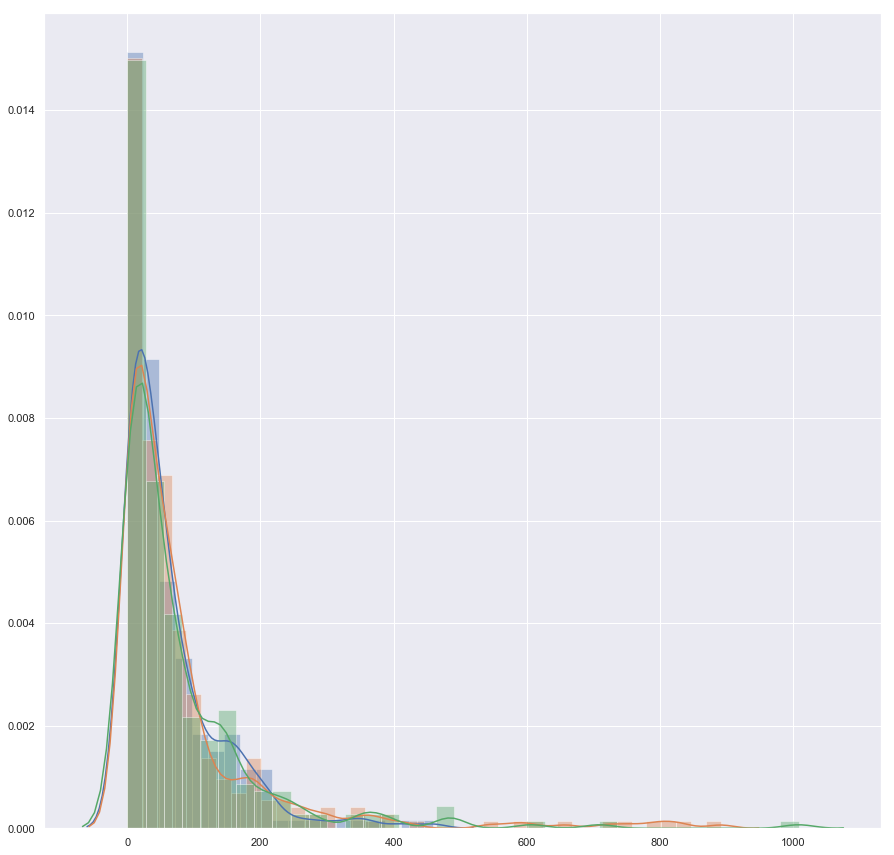